> NOTE: This notebook is still under active construction!

The following questions concern four data sets provided as a csv files:
`dataSet1.csv`, `dataSet2.csv`, `dataSet3.csv`, and `dataSet4.csv`.
Each csv file is organized such that each row contains the true class (either 0 or 1), followed by the associated (2-dimensional) feature vector.

In [2]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline

# Import ML packages
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Set constants
POS_INF = float("inf")
NEG_INF = float("-inf")

In [3]:
def train_model(model_class, train_X, train_y):
    """Train your model.

    Parameters:
        - model_class (class): a standardlized class (data type) for classifications.
        - train_X (array-like of shape (n_samples, n_features)): features of each
        sample in training data.
        - train_y (array-like of shape (n_samples,)): true class of each sample
        in training data.

    Returns:
        model: a trained model object.
        `model` is initialized as an instance of the given model `class`, and is
        trained with `train_X` and `train_y` by calling the method `fit()`.
    """
    model = model_class()
    model.fit(train_X, train_y)
    return model


def get_decision_statistics(model, input_X):
    # WARNING: some models don't have a decision_function() method
    return model.decision_function(input_X)


def get_ROC_data(thresholds, truth, decision_stats):
    """Create a Pandas dataframe contains thresholds, P_d and P_fa.

    Parameters:
        - thresholds (pd.Series): a list of thresholds.
        - truth (pd.Series): true classes for each observation.
        - decision_stats (pd.Series): decision statistics of each observation.

    Returns:
        ROC_data: pd.Dataframe of shape (n_samples, 3)
        The first column of ROC_data is the list of thresholds; The second column
        is the percentage of detection (P_d), and the third column is the percentage
        of false alarm (P_fa).

    """
    H0 = truth.value_counts().loc[0] # all true 0
    H1 = truth.value_counts().loc[1] # all true 1
    ROC_data = pd.DataFrame(thresholds, columns=["thresholds"])
    ROC_data["P_d"] = ROC_data.apply(lambda row:
                                sum((decision_stats>=row.thresholds) & (truth==1))/H1,
                                axis = 1)
    ROC_data["P_fa"] = ROC_data.apply(lambda row:
                                sum((decision_stats>=row.thresholds) & (truth==0))/H0,
                                axis = 1)
    return ROC_data


def draw_one_ROC(ROC_data, linecolor):
    """Draw one ROC curve.

    Parameters:
    - ROC_data (pd.Dataframe of shape (n_samples, 3)): a Dataframe that has three
    colomns, with the first column as the thresholds, second colummn as the P_d,
    and third column as the P_fa.
    - linecolor (string): an HTML color of the ROC curve.
    """
    _, ax = plt.subplots()
    plt.xlabel("P_fa")
    plt.ylabel("P_d")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    ax.scatter(ROC_data["P_fa"], ROC_data["P_d"], color=linecolor, s=8, marker="o")
    ax.plot(ax.get_xlim(), ax.get_ylim(), c="Black", alpha=0.6, ls='--') # diagonal
    plt.gca().set_box_aspect(1)
    plt.show()

## Example Question 1

In [4]:
data = pd.read_csv("../data/dataSet1.csv", names=["truth", "x1", "x2"])
train_X = data[["x1", "x2"]].values
train_y = data["truth"]
H0 = data["truth"].value_counts().loc[0] # all true 0
H1 = data["truth"].value_counts().loc[1] # all true 1

model = train_model(LinearDiscriminantAnalysis, train_X, train_y)
decision_stats = get_decision_statistics(model, train_X)

Here we try different methods to generate a list of thresholds to plot the ROC curves.

In [5]:
extra = pd.Series([POS_INF, NEG_INF])

# Method 1: Every decision statistics as a threshold
thresholds_1 = pd.Series(decision_stats)
thresholds_1 = pd.concat([thresholds_1, extra], ignore_index=True)
thresholds_1.sort_values(inplace=True)

# Method 2: 99 linearly sample the decision statistics as a threshold
min_lambda = decision_stats.min()
max_lambda = decision_stats.max()
thresholds_2 = pd.Series(np.linspace(min_lambda, max_lambda, 99))
thresholds_2 = pd.concat([thresholds_2, extra], ignore_index=True)
thresholds_2.sort_values(inplace=True)

# Method 3: sample every n-th decision statistics as a threshold
n = len(decision_stats) // 99 if len(decision_stats) >= 99 else 1
thresholds_3 =  pd.Series(decision_stats).sort_values().iloc[::n]
thresholds_3 = pd.concat([thresholds_3, extra], ignore_index=True)
thresholds_3.sort_values(inplace=True)

# Method 4: every H0 decision statistic as a threshold
thresholds_4 = pd.Series(decision_stats)[data["truth"]==0]
thresholds_4.sort_values(inplace=True)
thresholds_4 = pd.concat([thresholds_4, extra], ignore_index=True)
thresholds_4.sort_values(inplace=True)

# Method 5: thresholds selected so that PFA is linearly sampled from 0 to 1
# at an interval of 0.01
n = H0 // 100 if len(decision_stats) >= 100 else 1
thresholds_5 = pd.Series(decision_stats)[data["truth"]==0].sort_values().iloc[::n]
thresholds_5.sort_values(inplace=True)

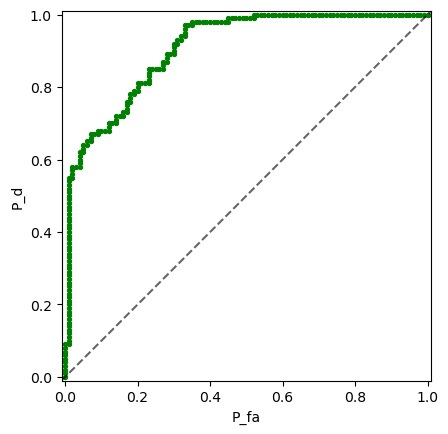

In [6]:
ROC_data = get_ROC_data(thresholds_1, train_y, decision_stats)
draw_one_ROC(ROC_data, "green")

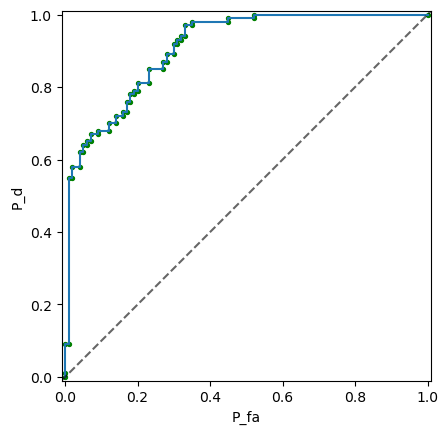

In [7]:
# Use roc_curve() function provided by sklearn to draw the ROC curve.
from sklearn.metrics import roc_curve
p_fa, p_d, thresholds = roc_curve(train_y, decision_stats)

_, ax = plt.subplots()
plt.scatter(p_fa, p_d, label="ROC curve", s=8, c="green")
plt.plot(p_fa, p_d, label="ROC curve")
plt.xlabel("P_fa")
plt.ylabel("P_d")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
ax.plot(ax.get_xlim(), ax.get_ylim(), c="Black", alpha=0.6, ls='--')
plt.gca().set_box_aspect(1)
plt.show()

## Example Question 2

In [34]:
def roc_curves_visual_cmp(ROC_data1, ROC_data2):
    plt.subplots()
    plt.xlabel("P_fa")
    plt.ylabel("P_d")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.plot(ROC_data1["P_fa"], ROC_data1["P_d"], c="b", lw=1, label="Benchmark")
    plt.plot(ROC_data2["P_fa"], ROC_data2["P_d"], c="r", lw=1, label="Student")
    Pd_2_interp = np.interp(ROC_data1["P_fa"], ROC_data2["P_fa"], ROC_data2["P_d"])
    plt.fill_between(ROC_data1["P_fa"], ROC_data1["P_d"], Pd_2_interp,
                     interpolate=True, color="green", alpha=0.5)
    plt.plot(ax.get_xlim(), ax.get_ylim(), c="black", alpha=0.6, ls='--') # diagonal
    plt.legend()
    plt.gca().set_box_aspect(1)
    plt.show()


def get_ABC(ROC_data1, ROC_data2):
    Pd_2_interp = np.interp(ROC_data1["P_fa"], ROC_data2["P_fa"], ROC_data2["P_d"])
    roc_diff = np.abs(ROC_data1["P_d"] - Pd_2_interp)
    abc = integrate.trapz(roc_diff, ROC_data1["P_fa"])
    return abc


In [9]:
data_4 = pd.read_csv("../data/dataSet4.csv", names=["truth", "x", "y"])
data_4 = data_4[["x", "y", "truth"]]
X_4 = data_4[["x", "y"]].values
y_4 = data_4["truth"]

In [11]:
correct_clf = SVC(C=0.001, kernel="linear")
correct_clf.fit(X_4, y_4)
correct_decision_stats = correct_clf.decision_function(X_4)

In [12]:
extra = pd.Series([POS_INF, NEG_INF])
thresholds = pd.Series(correct_decision_stats)
thresholds = pd.concat([thresholds, extra], ignore_index=True)
# NOTE: thresholds must be increasing for the convenince of interpolation.
thresholds.sort_values(inplace=True, ascending=False)

In [13]:
student_1_clf = SVC(C=1000, kernel="linear")
student_1_clf.fit(X_4, y_4)
student_1_decision_stats = student_1_clf.decision_function(X_4)

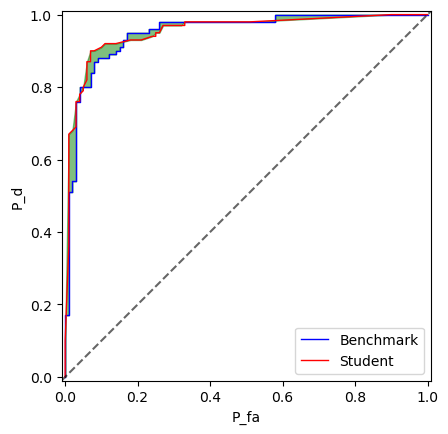

In [14]:
correct_clf_ROC_data = get_ROC_data(thresholds, y_4, correct_decision_stats)
student_1_clf_ROC_data = get_ROC_data(thresholds, y_4, student_1_decision_stats)
roc_curves_visual_cmp(correct_clf_ROC_data, student_1_clf_ROC_data)

In [16]:
ABC = get_ABC(correct_clf_ROC_data, student_1_clf_ROC_data)
print(f"The ABC between the student's clf and the benchmark is {ABC:.3f}.")

The ABC between the student's clf and the benchmark is 0.016.


In [17]:
student_2_clf = SVC(C=10000, kernel="rbf")
student_2_clf.fit(X_4, y_4)
student_2_decision_stats = student_2_clf.decision_function(X_4)

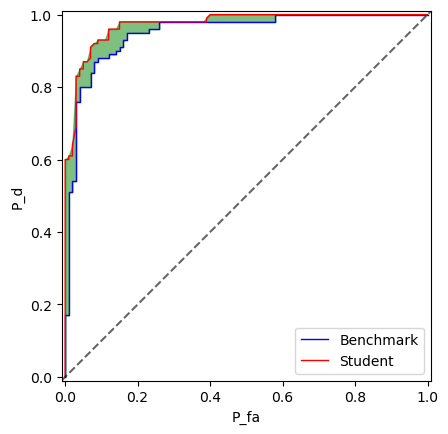

In [18]:
correct_clf_ROC_data = get_ROC_data(thresholds, y_4, correct_decision_stats)
student_2_clf_ROC_data = get_ROC_data(thresholds, y_4, student_2_decision_stats)
roc_curves_visual_cmp(correct_clf_ROC_data, student_2_clf_ROC_data)

In [19]:
ABC = get_ABC(correct_clf_ROC_data, student_2_clf_ROC_data)
print(f"The ABC between the student's clf and the benchmark is {ABC:.3f}.")

The ABC between the student's clf and the benchmark is 0.023.


## Example Question 3

In [24]:
log_norm_decision_stats = pd.read_csv("../data/logNormalData.csv", names=["truth", "lambda"])
y = log_norm_decision_stats["truth"]
decision_stats = log_norm_decision_stats["lambda"]

In [41]:
extra = pd.Series([POS_INF, NEG_INF])

# Method 1: Every decision statistics as a threshold
thresholds_1 = pd.Series(decision_stats)
thresholds_1 = pd.concat([thresholds_1, extra], ignore_index=True)
thresholds_1.sort_values(inplace=True, ascending=False)

# Method 2: 99 linearly sample the decision statistics as a threshold
min_lambda = decision_stats.min()
max_lambda = decision_stats.max()
thresholds_2 = pd.Series(np.linspace(min_lambda, max_lambda, 99))
thresholds_2 = pd.concat([thresholds_2, extra], ignore_index=True)
thresholds_2.sort_values(inplace=True, ascending=False)

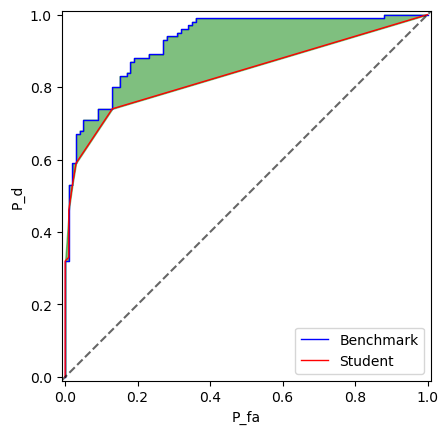

The ABC between the student's clf and the benchmark is 0.090.


In [42]:
correct_clf_ROC_data = get_ROC_data(thresholds_1, y, decision_stats)
student_clf_ROC_data = get_ROC_data(thresholds_2, y, decision_stats)
roc_curves_visual_cmp(correct_clf_ROC_data, student_clf_ROC_data)
ABC = get_ABC(correct_clf_ROC_data, student_clf_ROC_data)
print(f"The ABC between the student's clf and the benchmark is {ABC:.3f}.")